# Description
Fitting b1 and beta for different density bins by minimizing $\chi^2$. Based on ideas laid out in `Fitting_b1_different_kmax.ipynb`.

The 2D power spectrum for each density bin has been computed and stored by `power_densitybins.py`. This data is loaded and used to compute the multipoles in each bin inside `inv_cov_funcs.load_power_data`. 

The reason to divide the sample into density bins is to later analyze the cross correlation between the subsamples to investigate relativistic effects.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.optimize import minimize
from scipy.special import legendre

import inv_cov_funcs as icf
import classylss
import fitsio
from nbodykit.lab import *
from nbodykit import style, setup_logging
#setup_logging()
plt.style.use(style.notebook)

In [3]:
LOS = [0,0,1]
redshift = 0
BoxSize = 2000
cosmo_paras = classylss.load_ini('/home/jwack/main/Planck18_LCDM.ini')
cosmo = cosmology.cosmology.Cosmology.from_dict(cosmo_paras)
Plin = cosmology.LinearPower(cosmo, redshift, transfer='EisensteinHu') # linear matter power spectrum 
sigma8_lin = Plin.sigma8
sigma8_true = 0.8111 
f0_true = cosmo.scale_independent_growth_rate(redshift)

dk = 0.01
ells = [0,2]

/home/jwack/.conda/envs/nbodykit-env/lib/python3.8/site-packages/nbodykit/cosmology/cosmology.py:427: UserWarning: Class did not read input parameter(s): sigma_8, w0_fld, wa_fld
  self.engine = ClassEngine(pars)
/home/jwack/.conda/envs/nbodykit-env/lib/python3.8/site-packages/nbodykit/cosmology/cosmology.py:427: UserWarning: Class did not read input parameter(s): sigma_8
  self.engine = ClassEngine(pars)


In [4]:
# load computed power spectra to deduce multipoles in each bin
k, shotnoise, n_ptile, Pk_ells = icf.load_power_data('/home/jwack/main/fit_linear_model_in_density_bins/', ells, get_Pkmus=False)

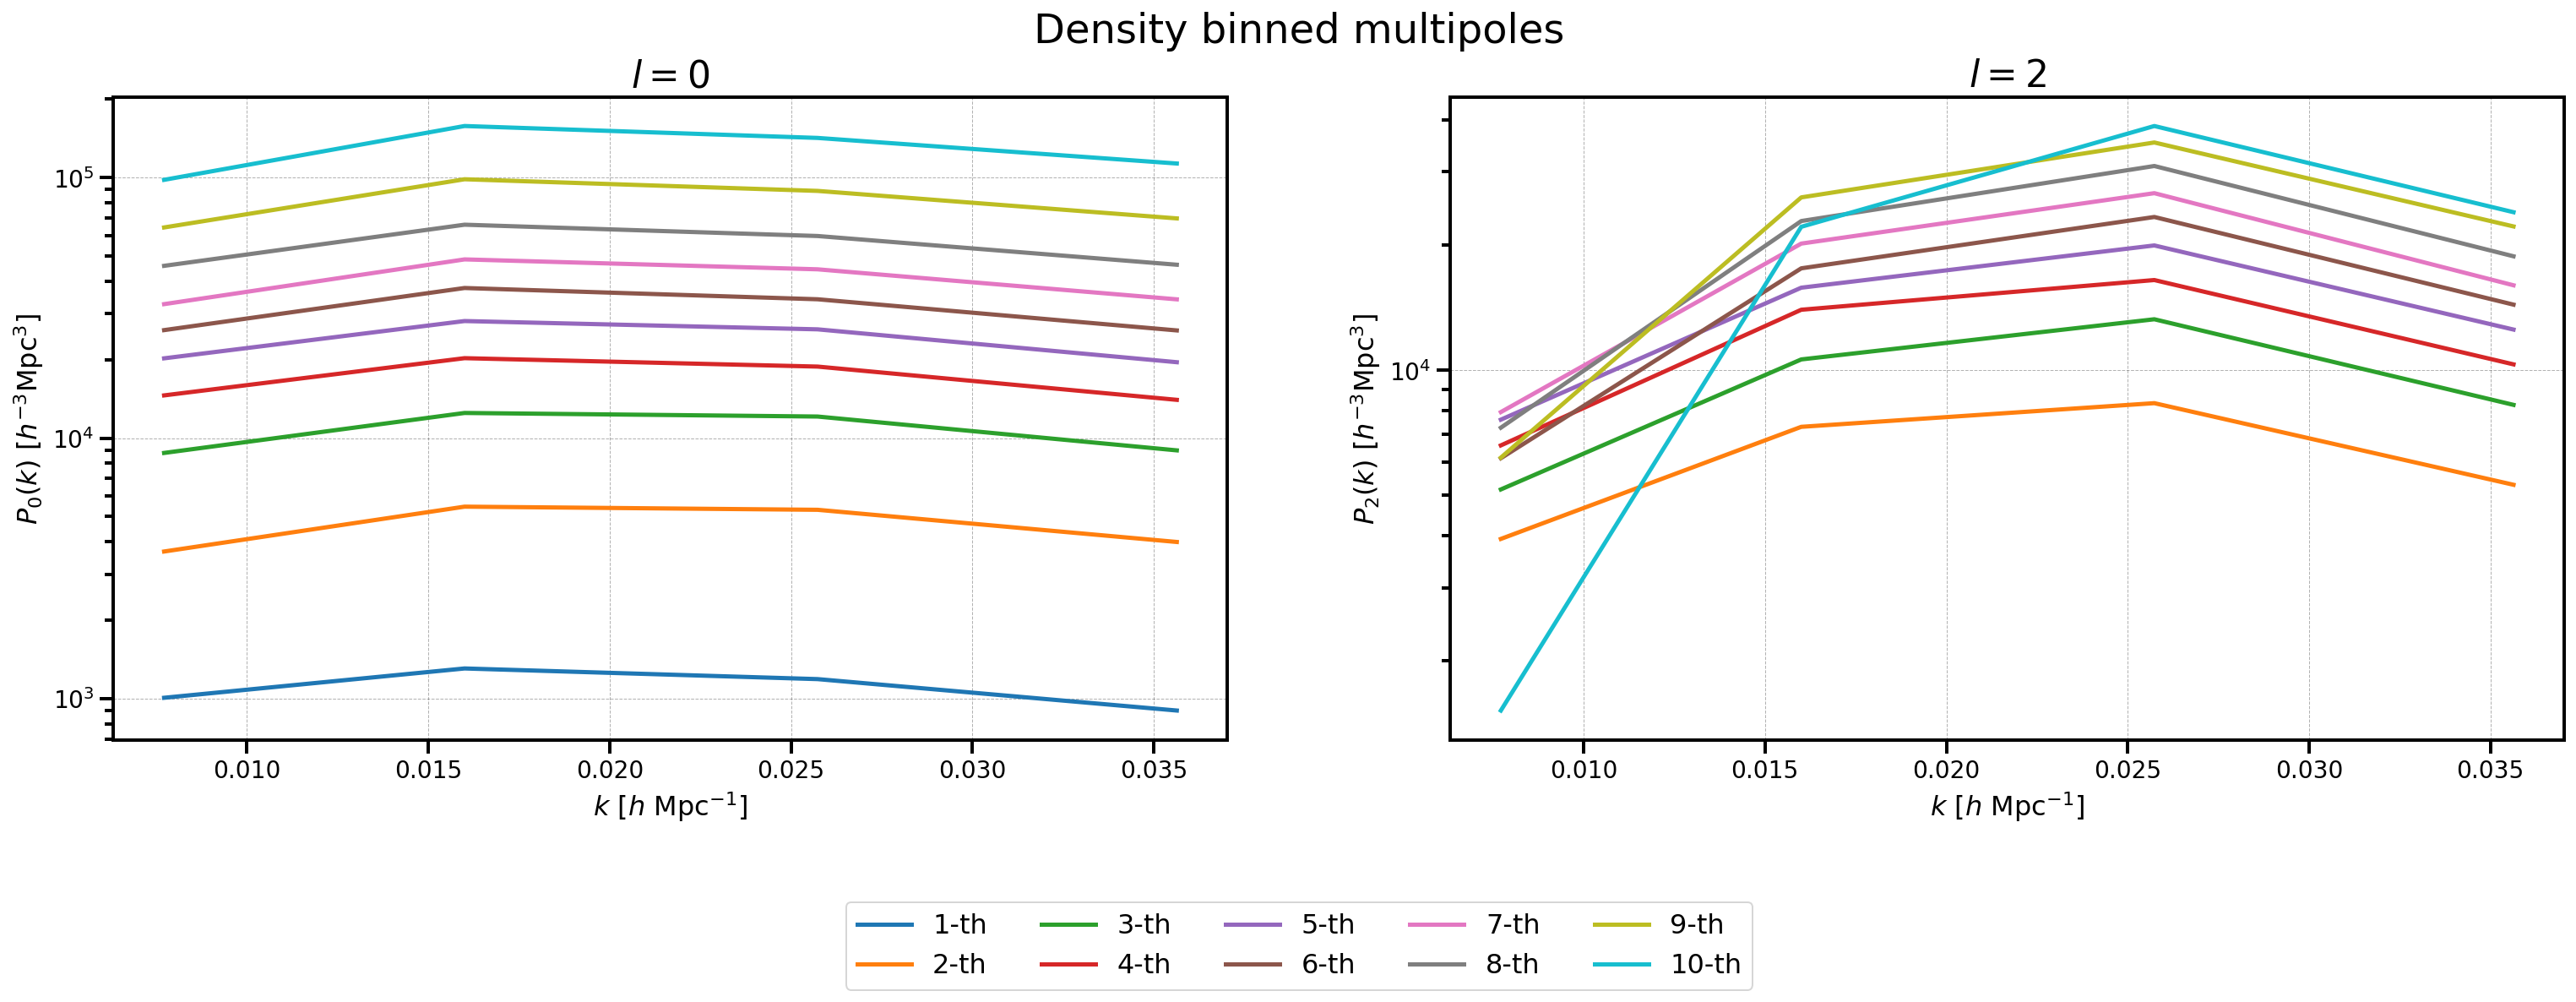

In [6]:
# plot mulipoles as function of k for each density bin
fig, axs = plt.subplots(1, len(ells), figsize=(26,7))

for j, ell in enumerate(ells):
    for i in range(n_ptile):
        axs[j].plot(k, Pk_ells[i][j], label='%d-th'%(i+1))
        
    #axs[j].set_title("Density separated multipole $l=%d$"%ell)
    axs[j].set_title("$l=%d$"%ell)
    axs[j].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
    axs[j].set_ylabel(r"$P_%d(k)$ [$h^{-3}\mathrm{Mpc}^3$]"%ell)
    axs[j].set_yscale('log')
    
fig.suptitle('Density binned multipoles', fontsize=24)
handles, labels = axs[j].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=5)
plt.show()
#fig.savefig("plots/multipoles_densities_binned.pdf")

### Interpretation
As the density increases, the power spectrum amplitude increases. This is expected since in high density regions are regions of enhanced clustering. Since the power spectrum is the FT of the 2 point correlation function, whose amplitude measures the amount of clustering. For greater amounts of clustering we expect to need a larger value of the bias to reproduce the multipole with the model.

Note that when computing for large $k$ we find some multipoles to become negative, which cannot be reproduced by the model. On a log scale this is manifested as a cut of the multipole plot and occurs for:
- $l=0:$ 1st percentile $k\approx 0.2$
- $l=2:$ 9st percentile $k\approx 0.145$, 10st percentile $k\approx 0.08$

To ensure sensible fitting parameters, only consider up to $k \approx 0.05$ i.e. slice `k[:5]`

### Fit b1 and beta for each density bin and multipole
When fitting $\beta$ and $b1$, we can compute the growth rate at $z=0$ via $f_0 = b1*\beta$ which should be the same for all density bins. The true value can be deduced from the cosmological parameters only via `f0_true = cosmo.scale_independent_growth_rate(redshift)`. Often surveys are sensitive only to $\sigma_8 * f_0$. Where the true (used in the simulation) value of $\sigma_8$ is given in `Planck18_LCDM.ini` (problem with reading the attribute, hence hard coded). To assert the quality of the fit we compare the true value of $f_0*\sigma_8$ to the fitted one i.e. `b1_fit * beta_fit * sigma8_lin`.
Fitting procedure is analogous to `Fitting_b1_different_kmax.ipynb` but now having 2 free parameters. The linear theory predictions for the multipoles are (eq 5.7 in Hamilton's review):

$$
P_0^s(k) = (1 + \frac{2}{3}\beta + \frac{1}{5}\beta^2 )P(k), \quad P_2^s(k) = ( \frac{4}{3}\beta + \frac{4}{7}\beta^2 )P(k)
$$

where the real space power spectrum $P(k)$ is related to the matter power spectrum $P_m(k)$ via $P(k) = b1^2P_m(k)$. 
Hard coding the multipoles is less flexible (only works for purely linear Kaiser theory and $l=0,2$) than projecting some more general model $P(k,\mu)$ onto Legendre polynomials. This can be done via:
```
model_multipoles = np.empty((len(ells), len(k)))
for i,ell in enumerate(ells):
    model_multipoles[i] = in_cov_funcs.model_multipole(k, ell, b1, beta, Plin)
```
where `in_cov_funcs.make_Pkmu` calls the desired model.

In [7]:
def chi2(theta, k, data_multipoles, BoxSize, shotnoise, dk, Plin):
    '''Find chi^2 as explained in Fitting_b1_different_kmax.ipynb. 
    data_multipoles must be an array of shape (len(ells), len(k)).
    theta is the model parameter array: theta = [b1, beta]. See above markdown for more general alternative.'''
    b1, beta = theta
    ells = [0,2]
    # make model vector
    model_multipoles = np.empty((len(ells), len(k)))
    model_multipoles[0] = (1 + 2/3*beta + 1/5*beta**2) * b1**2 * Plin(k)
    model_multipoles[1] = (4/3*beta + 4/7*beta**2) * b1**2 * Plin(k)
        
    D_M = (data_multipoles - model_multipoles).flatten()
    #C_inv = gaussian_cov_mat_inv(k, ells, b1, beta, shotnoise, dk)
    Pkmu, mus = icf.make_Pkmu(k, b1, beta, Plin)
    C_inv = icf.gaussian_cov_mat_inv(k, ells, BoxSize, shotnoise, dk, Pkmu, mus)
    
    return D_M@(C_inv @ D_M)

In [8]:
b1_fits, beta_fits, chi2_mins = np.empty(n_ptile), np.empty(n_ptile), np.empty(n_ptile)

for i in range(n_ptile):
    t1 = time.time()
    # change data format of Pk_ells to be compatible with chi2 minimization code 
    data_multipoles = np.empty((len(ells), len(k)))
    data_multipoles[0] = Pk_ells[i][0]
    data_multipoles[1] = Pk_ells[i][1]
    s = minimize(chi2, [1, 0.5], args=(k, data_multipoles, BoxSize, shotnoise, dk, Plin), bounds=((None, None), (None, None)))
    b1_fits[i] = s.x[0]
    beta_fits[i] = s.x[1]
    chi2_mins[i] = s.fun
    t2 = time.time()
    print("Fitted %d-th percentile in %.2f sec"%(i+1,t2-t1))

Fitted 1-th percentile in 0.61 sec
Fitted 2-th percentile in 0.73 sec
Fitted 3-th percentile in 0.88 sec
Fitted 4-th percentile in 0.49 sec
Fitted 5-th percentile in 0.39 sec
Fitted 6-th percentile in 0.43 sec
Fitted 7-th percentile in 0.46 sec
Fitted 8-th percentile in 0.47 sec
Fitted 9-th percentile in 0.54 sec
Fitted 10-th percentile in 0.55 sec


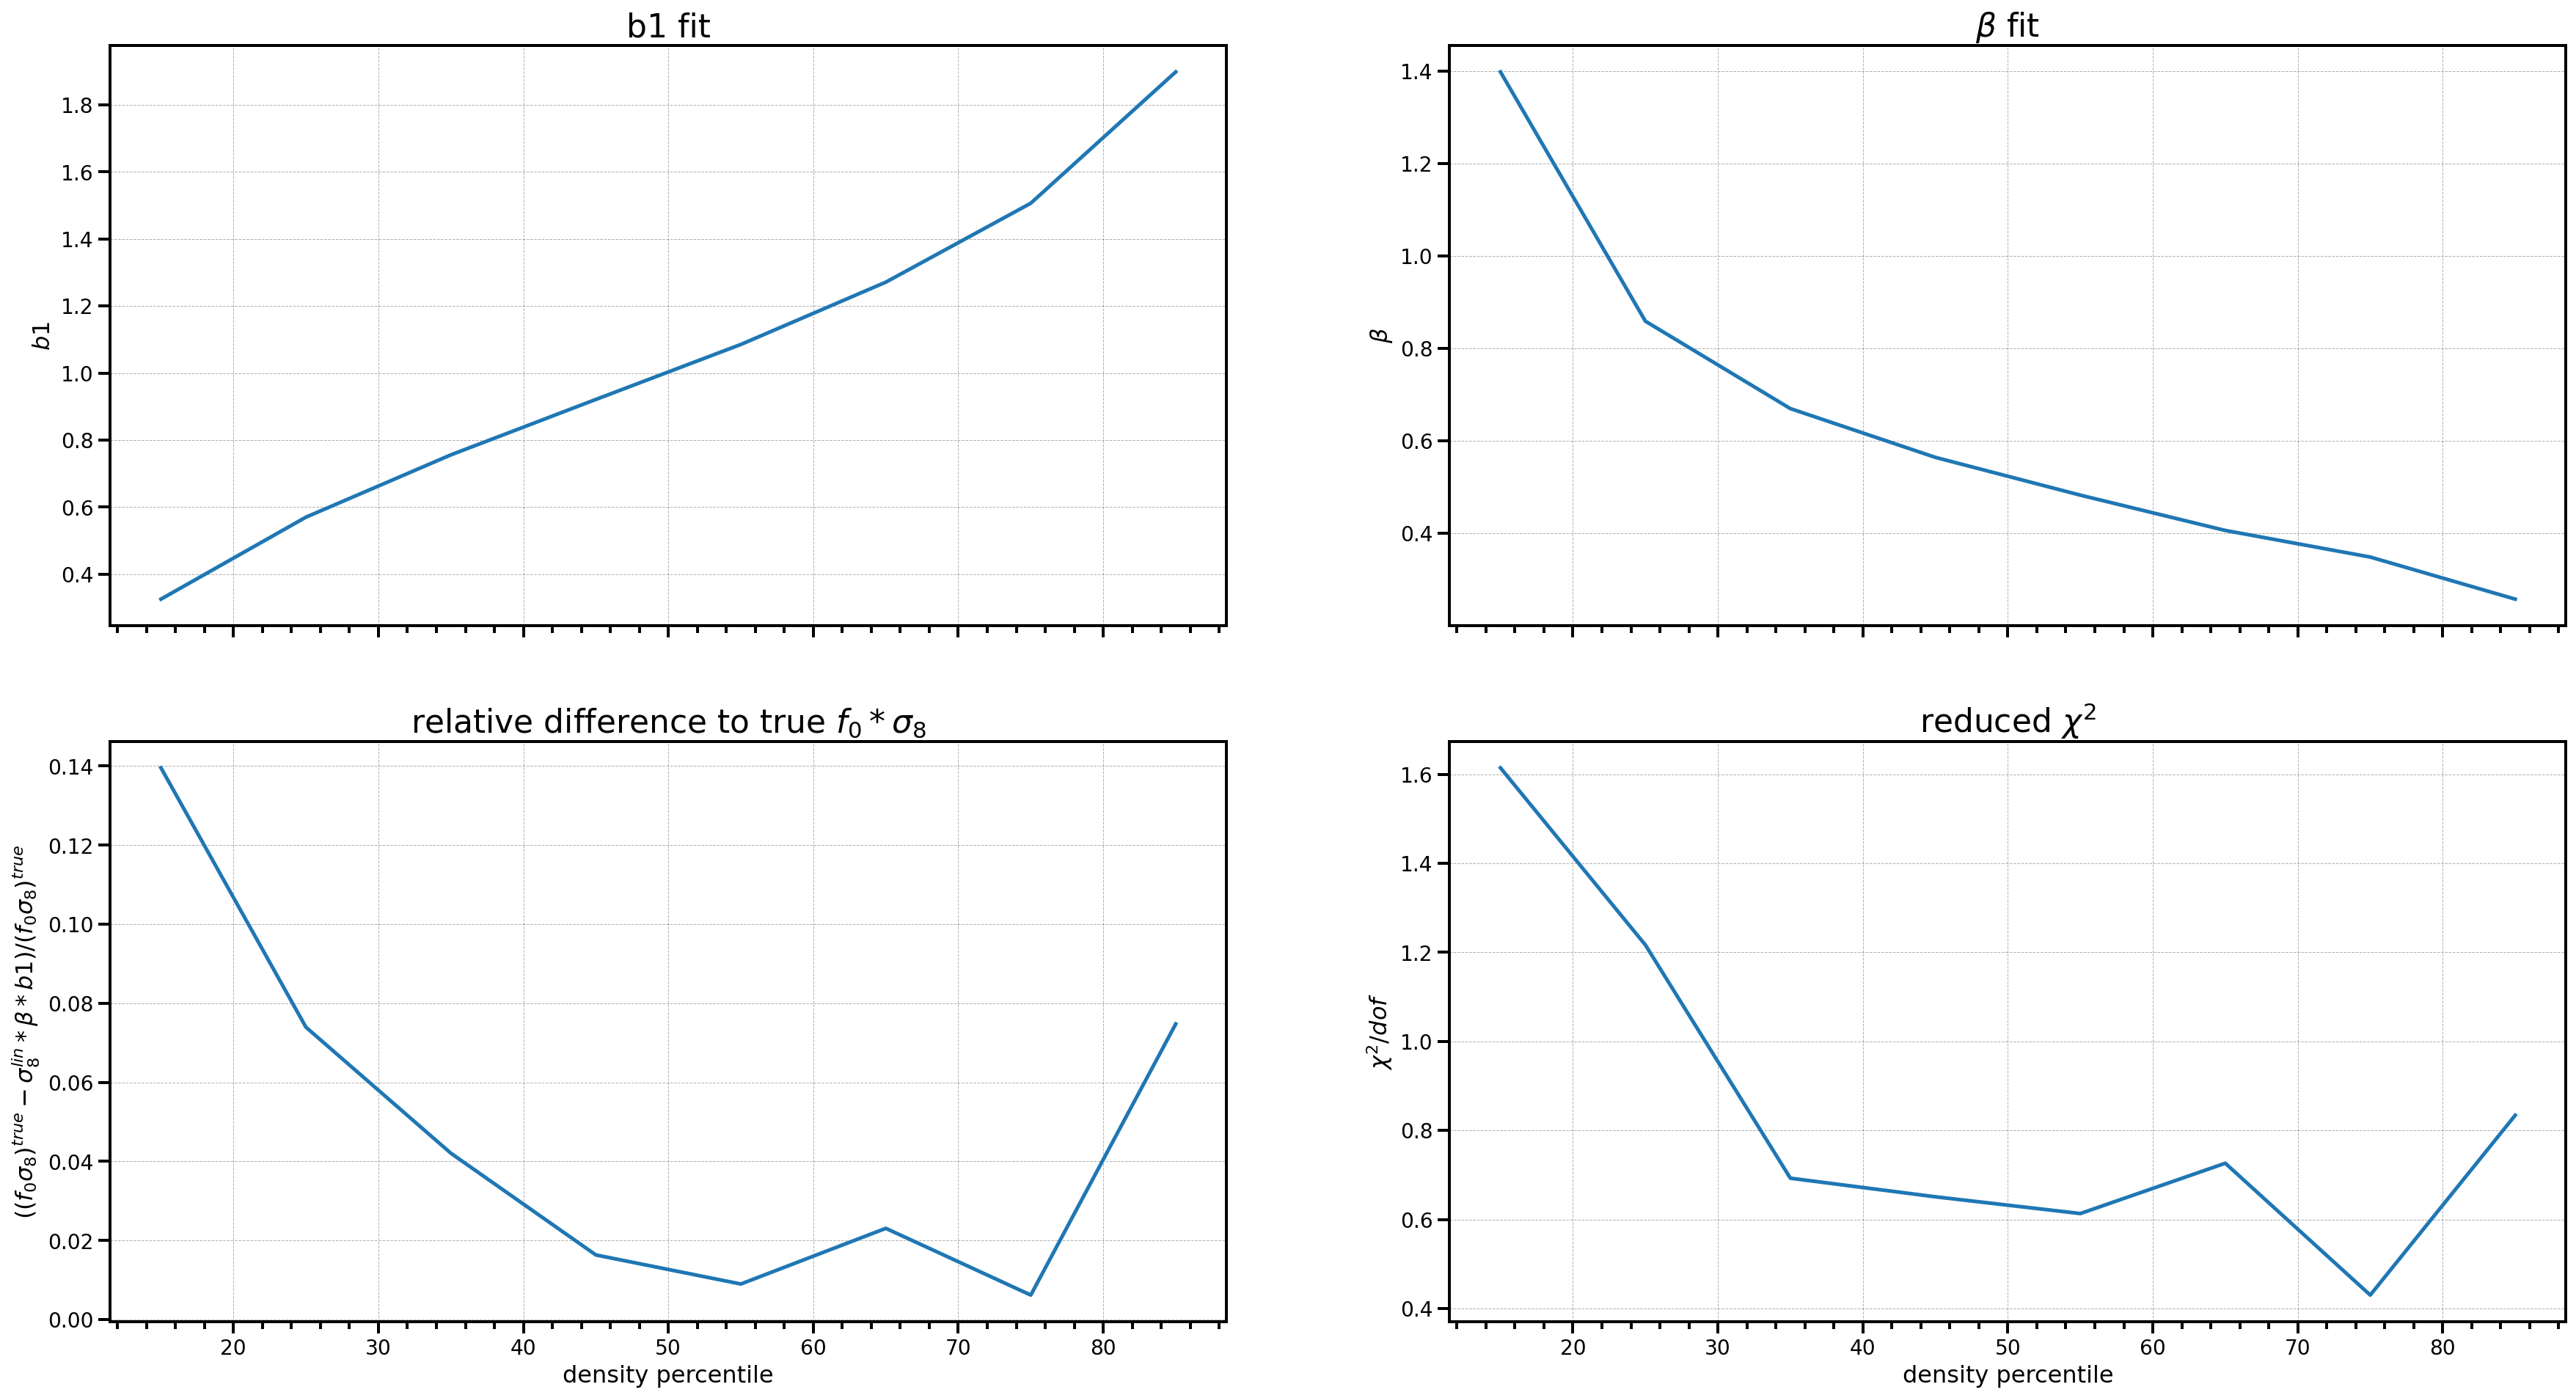

In [9]:
from matplotlib.ticker import AutoMinorLocator
fig, axs = plt.subplots(2, 2, figsize=(30,16), sharex=True)

mids = np.arange(5,105,10)[1:-1] # percentile mid points

axs[0][0].plot(mids, b1_fits[1:-1])
axs[0][0].set_title("b1 fit")
#axs[0][0].set_xlabel("density percentile")
axs[0][0].set_ylabel(r"$b1$")

axs[0][1].plot(mids, beta_fits[1:-1])
axs[0][1].set_title(r"$\beta$ fit")
#axs[0][1].set_xlabel("density percentile")
axs[0][1].set_ylabel(r"$\beta$")

axs[1][0].plot(mids, (f0_true*sigma8_true - sigma8_lin*(beta_fits*b1_fits)[1:-1]) / (f0_true*sigma8_true))
axs[1][0].set_title(r"relative difference to true $f_0*\sigma_8$")
axs[1][0].set_xlabel("density percentile")
axs[1][0].set_ylabel(r"$((f_0\sigma_8)^{true} - \sigma_8^{lin}*\beta*b1)/(f_0\sigma_8)^{true}$")
axs[1][0].xaxis.set_minor_locator(AutoMinorLocator())

# For each of l=0,2 we have data_multipoles.shape[1] k bins. Fitting two parameters gives DOF
reduced_chi2 = chi2_mins/(2*data_multipoles.shape[1] - 2)
axs[1][1].plot(mids, reduced_chi2[1:-1])
axs[1][1].set_title("reduced $\chi^2$")
axs[1][1].set_xlabel("density percentile")
axs[1][1].set_ylabel(r"$\chi^2 / dof$")
axs[1][1].xaxis.set_minor_locator(AutoMinorLocator())

plt.show()
#fig.savefig('plots/Fitting_b1_beta_densitybins_minchi2.pdf')

### Interpretation
Without negative multipoles (i.e kmax=0.05) and ignoring the first percentile, get okay fitted parameters and reduced chi2 of around 1. The quality of the first near the end density bins is not good as see in f0 plot. A potential reason why f0 is systematically underestimated could be not including a "Finger of God" term in model. FOG cause RSD to be diluted such that a lower growth rate is inferred.

The issue with the first percentile is the quadrupole is entirely negative, causing a negative beta is fitted. Even though the resulting chi2 is small, the inferred f0 is far off. Bounding beta to be non-negative gives beta=0 in the 1st percentile, causing $P_0^{model}(k) \sim P_{matter}(k), P_2^{model}(k) = 0$ and hence a large $\chi^2$.